In [1]:
import pandas as pd

# Loading dataset

# words_df = pd.read_csv('data/Indian-Male-Names.csv')
words_df = pd.read_csv('data/Indian-Female-Names.csv')
words_list = words_df.values.tolist()

# First 10 names
import re
patt = r'^[A-Za-z\s]+$'
words = [w[0].split()[0] for w in words_list if type(w[0]) == str and bool(re.match(patt, w[0]))]
words[:10]

['shivani',
 'isha',
 'smt',
 'divya',
 'mansi',
 'mazida',
 'pooja',
 'kajal',
 'meena',
 'sonam']

In [2]:
# loading dataset
# words = open('names.txt', 'r').read().splitlines()
# words[:10]

In [3]:
max(map(lambda x : len(x),words)) #maximum length word

13

In [4]:
min(len(x) for x in words) #minimum length word

1

In [5]:
import torch

In [6]:
# creating a grid for plotting and count of occurrences
N = torch.zeros((27,27), dtype=torch.int32)

In [7]:
chars = list("abcdefghijklmnopqrstuvwxyz")

# creating string to integer map
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

In [8]:
# creating integer to string map
itos = {i+1:s for i, s in enumerate(chars)}
itos[0] = '.'

In [9]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [10]:
# counting the occurrences of all possible bigrams
for w in words:
    chs = ['.'] + list(w) + ['.'] #start and end marker
    for c1, c2 in zip(chs, chs[1:]):
#         print(c1, c2)
        i1 = stoi[c1]
        i2 = stoi[c2]
        N[i1, i2] += 1

(-0.5, 26.5, 26.5, -0.5)

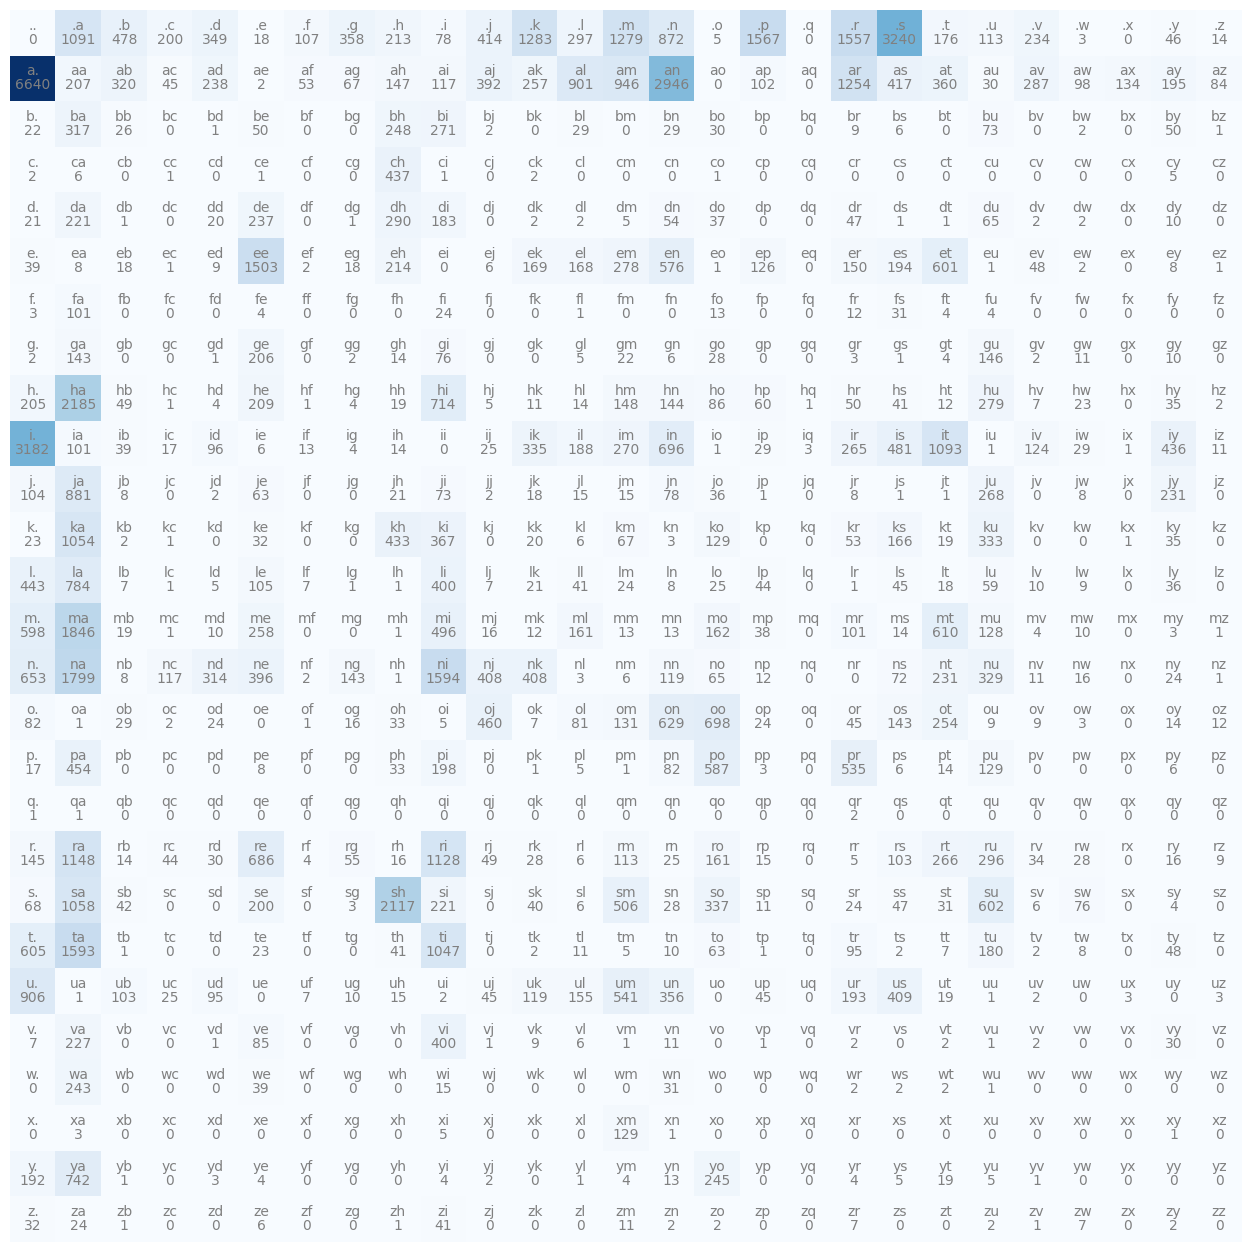

In [11]:
# plotting the bigrams alongwith counts
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [12]:
# Calculating probablity for the first row of the matrix
p = N[0].float()
p /= p.sum()
p

tensor([0.0000e+00, 7.7973e-02, 3.4162e-02, 1.4294e-02, 2.4943e-02, 1.2864e-03,
        7.6472e-03, 2.5586e-02, 1.5223e-02, 5.5746e-03, 2.9588e-02, 9.1695e-02,
        2.1226e-02, 9.1409e-02, 6.2321e-02, 3.5735e-04, 1.1199e-01, 0.0000e+00,
        1.1128e-01, 2.3156e-01, 1.2579e-02, 8.0760e-03, 1.6724e-02, 2.1441e-04,
        0.0000e+00, 3.2876e-03, 1.0006e-03])

In [13]:
# drawing a random samples with provided probablities using multinomial function of pytorch
g = torch.Generator().manual_seed(2147483647)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(idx)

13


In [14]:
# creating probablity matrix alongwith smoothing out the probablity as 0 probablity creates inconsistency (log of 0 is not defined)
P = (N.float()+1)
P /= P.sum(1, keepdim=True)

In [15]:
# sampling using bigram model
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    idx = 0
    out = []
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        out.append(itos[idx])
    print("".join(out))

munidekiti
sa
su
smayoojna
kurinitolita


In [16]:
# To calculate some kind of loss, negative log likelihood is used where given multiple probablities, p1, p2,...pn,
# log likelihood is calculated as log(p1*p2....*pn) = log(p1)+log(p2)+.....log(pn)

# calculating negative log likelihood of the given bigram model
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.'] #start and end marker
    for c1, c2 in zip(chs, chs[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        n += 1
        p = P[i1, i2]
        log_likelihood += torch.log(p)
print(f'norm_negative_log_liklihood : {-log_likelihood/n}') # The less the better

norm_negative_log_liklihood : 2.062439441680908


## Using Neural Network

In [17]:
# seperating the data and the labels
xs , ys = [], []
for word in words:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        xs.append(i1)
        ys.append(i2)
x = torch.tensor(xs)
y = torch.tensor(ys)
num = x.nelement()
print(x)
print(y)

tensor([ 0, 19,  8,  ..., 25, 14,  1])
tensor([19,  8,  9,  ..., 14,  1,  0])


In [18]:
# Initializing weights with random values
g = torch.Generator().manual_seed(2147483647)
w = torch.randn((27,27), generator=g, requires_grad=True)

In [19]:
import torch.nn.functional as F
losses , it = [], []
for i in range(100):
    #forward pass
    
    #Using one hot encoding as the input to the layers
    xenc = F.one_hot(x, num_classes=27).float()
    logits = xenc@w #returned values are logged values
    
    # So taking exponentiation and normalizing -> otherwise known as softmax
    e = logits.exp()
    probs = e/e.sum(1, keepdims=True)
    
    # Calculating the negative log likelihood with regularization
    loss = -probs[torch.arange(num), y].log().mean() + 0.01*(w**2).mean()
    print(f'Loss: {loss}')
    losses.append(loss.item())
    it.append(i)
    #backward pass
    w.grad = None
    loss.backward()
    lr = 10
    #update
    w.data += -lr*w.grad
print(f'Loss: {loss}')

Loss: 3.827038049697876
Loss: 3.6540722846984863
Loss: 3.498786687850952
Loss: 3.362666368484497
Loss: 3.247474193572998
Loss: 3.152272939682007
Loss: 3.07303786277771
Loss: 3.00545072555542
Loss: 2.946720838546753
Loss: 2.895258665084839
Loss: 2.849963665008545
Loss: 2.809892177581787
Loss: 2.7741973400115967
Loss: 2.742142915725708
Loss: 2.713121175765991
Loss: 2.6866440773010254
Loss: 2.662325382232666
Loss: 2.639859437942505
Loss: 2.6190009117126465
Loss: 2.599552869796753
Loss: 2.5813536643981934
Loss: 2.56427264213562
Loss: 2.5482020378112793
Loss: 2.533051013946533
Loss: 2.518745183944702
Loss: 2.505221128463745
Loss: 2.4924240112304688
Loss: 2.480306625366211
Loss: 2.468824625015259
Loss: 2.457939624786377
Loss: 2.4476137161254883
Loss: 2.437812566757202
Loss: 2.4285025596618652
Loss: 2.419651746749878
Loss: 2.411229133605957
Loss: 2.4032058715820312
Loss: 2.3955540657043457
Loss: 2.388247013092041
Loss: 2.3812620639801025
Loss: 2.374575614929199
Loss: 2.3681678771972656
Loss: 

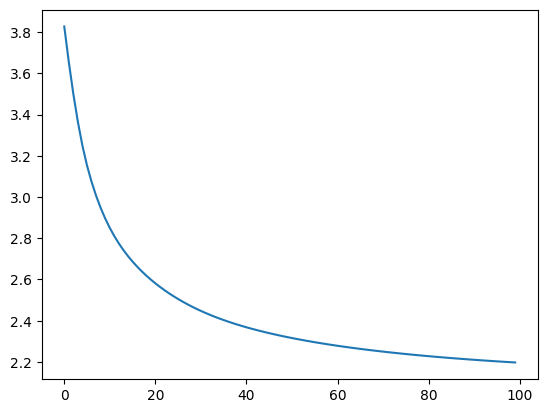

In [20]:
plt.plot(it, losses)

## Randomly generating new names

In [21]:
g = torch.Generator().manual_seed(2147483647)

In [22]:
#sampling using neural network
for i in range(10):
    i = 0
    out = []
    while True:
        xenc = F.one_hot(torch.tensor([i]), num_classes=27).float()
        logits = xenc@w
        e = logits.exp()
        p = e/e.sum(1, keepdims=True)
        
        i = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[i])
        if(i == 0):
            break
    name = ''.join(out)
    if name[:-1] not in words:
        print(name[:-1])
    

munidediti
sa
su
sfbywa
kui
ritozita
sumt
smannia
ranileviajadbyainrwi


In [23]:
#sampling using bigram model
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    i = 0
    out = []
    while True:
        p = P[i]
        i = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[i])
        if(i == 0):
            break
    name = ''.join(out)
    if name[:-1] not in words:
        print(name[:-1])
    

munidekiti
sa
su
smayoojna
kurinitolita
sumt
smannia
ranileniajadeeepniwa
shashaninay
